<a href="https://colab.research.google.com/github/Ssurf777/physics_informed_neural_network/blob/main/%E7%86%B1%E6%8B%A1%E6%95%A3%E6%96%B9%E7%A8%8B%E5%BC%8F%CE%B4%E9%96%A2%E6%95%B0%E3%81%AE%E3%82%AC%E3%82%A6%E3%82%B9%E8%BF%91%E4%BC%BC2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import random

# シードの設定
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

# 球体の点群生成関数
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi
    phi = torch.acos(2 * torch.rand(num_points) - 1)

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    points = torch.stack([x, y, z], dim=1)
    normalized_points = (points - points.min(dim=0)[0]) / (points.max(dim=0)[0] - points.min(dim=0)[0])
    return normalized_points

# ラプラシアン計算
def compute_laplacian(model, points):
    points.requires_grad_(True)
    T = model(points)
    grad_T = torch.autograd.grad(outputs=T, inputs=points,
                                 grad_outputs=torch.ones_like(T),
                                 create_graph=True)[0]
    laplacian = torch.sum(grad_T**2, dim=1).mean()
    return laplacian

#
def compute_laplacian2(model, points):
    points.requires_grad_(True)
    T = model(points)
    grad_T = torch.autograd.grad(outputs=T, inputs=points,
                                 grad_outputs=torch.ones_like(T),
                                 create_graph=True)[0]

    laplacian = torch.autograd.grad(outputs=grad_T, inputs=points,
                                grad_outputs=torch.ones_like(grad_T),
                                create_graph=True)[0]

    laplacian = torch.clamp(laplacian, min=-1e-5, max=1e-5)  # 勾配クリッピング
    laplacian = torch.sum(laplacian, dim=1).mean()
    return laplacian

# 有限要素的に２階微分を解く
def compute_laplacian_fd(model, points, h=1e-3):
    # 点群に微小変位を加える
    x = points.clone()
    x.requires_grad_(True)

    # 温度場の計算
    T = model(x)

    # 微小変位を加えて有限差分で二階微分を近似
    laplacian = torch.zeros_like(T)
    for i in range(points.shape[1]):
        dx = torch.zeros_like(points)
        dx[:, i] = h

        T_forward = model(x + dx)
        T_backward = model(x - dx)

        laplacian += (T_forward - 2 * T + T_backward) / (h**2)

    return laplacian.mean()



# PINNモデル定義
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 1)

        nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        nn.init.kaiming_uniform_(self.fc4.weight)

    def forward(self, x):
        x = torch.relu(self.fc1(x.float()))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        return self.fc4(x)

# 学習関数 (バッチ処理対応)
def autograd_train_pinn(model, points, heat_source, epochs=1000, batch_size=64):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    points = points.to(device)
    heat_source = heat_source.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    start_time = time.time()

    laplacian_log, delta_log = [], []
    num_batches = (len(points) + batch_size - 1) // batch_size

    for epoch in range(epochs):
        model.train()
        total_loss, total_laplacian_loss, total_delta_loss = 0, 0, 0

        for i in range(num_batches):
            batch = points[i * batch_size:(i + 1) * batch_size]
            distances = torch.norm(batch - heat_source, dim=1)

            epsilon = 0.15
            delta_approx = torch.exp(-(distances**2) / (2 * epsilon**2)) / (epsilon * np.sqrt(2 * np.pi))
            delta_approx /= torch.sum(delta_approx)  # 積分が1になるように正規化
            heat_source_term = delta_approx

            laplacian = compute_laplacian(model, batch)
            laplacian2 = compute_laplacian2(model, batch)
            laplacian_fd = compute_laplacian_fd(model, batch)
            loss_laplacian = laplacian2
            loss_temperature = torch.mean(heat_source_term)

            loss = loss_laplacian + loss_temperature

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            total_laplacian_loss += loss_laplacian.item()
            total_delta_loss += loss_temperature.item()

        laplacian_log.append(total_laplacian_loss / len(points))
        delta_log.append(total_delta_loss / len(points))

        if epoch % 100 == 0:
            elapsed_time = time.time() - start_time
            print(f"Epoch {epoch}/{epochs} | Laplacian Loss: {total_laplacian_loss:.6e} | delta_Loss: {total_delta_loss:.6e} | Loss: {total_loss:.6e} | Time: {elapsed_time:.2f}s")

    return laplacian_log, delta_log

# 球体点群生成とモデル学習
points = create_points(1000)
model = PINN()
laplacian_log, delta_log = autograd_train_pinn(model, points, torch.tensor([1, 1, 1]))

# 結果のプロット
plt.figure(figsize=(10, 6))
plt.plot(laplacian_log, label='Laplacian Loss')
plt.plot(delta_log, label='Delta Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


Epoch 0/1000 | Laplacian Loss: 0.000000e+00 | delta_Loss: 2.593750e-01 | Loss: 2.593750e-01 | Time: 0.10s


KeyboardInterrupt: 

4806.73681640625
1613.7042236328125


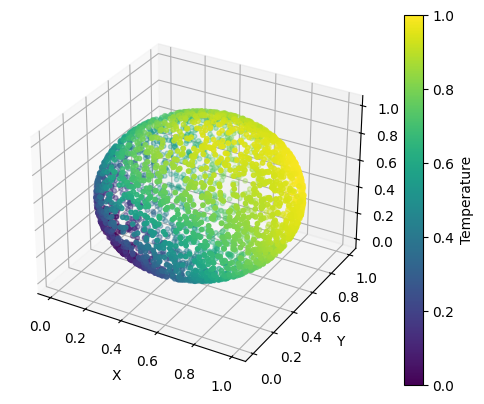

In [22]:
import plotly.graph_objects as go
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# デバイスの設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルをデバイスに転送
model.to(device)

# 球上の点群を生成
points = create_points(num_points=3000, radius=1.0).to(device)

# 温度推論
with torch.no_grad():
    predicted_temperatures = model(points).cpu().numpy().astype(float)  # データ型を指定
    predicted_temperatures = -1 * predicted_temperatures

print(predicted_temperatures.max())
print(predicted_temperatures.min())


normalized_temp = (predicted_temperatures - predicted_temperatures.min()) / \
                  (predicted_temperatures.max() - predicted_temperatures.min())



# 3Dプロットのセットアップ
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
normalized_temp = (predicted_temperatures - predicted_temperatures.min()) / \
                  (predicted_temperatures.max() - predicted_temperatures.min())
# 温度に応じたカラーマッピング
sc = ax.scatter(points[:, 0].cpu().numpy(),
                points[:, 1].cpu().numpy(),
                points[:, 2].cpu().numpy(),
                c=normalized_temp,
                cmap='viridis',  # カラーマップの指定
                s=10)  # ポイントサイズ

# カラーバーの追加
cb = plt.colorbar(sc)
cb.set_label('Temperature')

# 軸ラベル
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

# 形状ファイル

In [ ]:
def read_off(file):
    if 'OFF' != file.readline().strip():
        raise ValueError('Not a valid OFF header')
    n_verts, n_faces, __ = tuple([int(s) for s in file.readline().strip().split(' ')])
    verts = [[float(s) for s in file.readline().strip().split(' ')] for i_vert in range(n_verts)]
    faces = [[int(s) for s in file.readline().strip().split(' ')][1:] for i_face in range(n_faces)]
    return verts, faces

# 内挿域サンプリング

In [ ]:
# 内挿域サンプリング
class PointSampler(object):
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size

    def triangle_area(self, pt1, pt2, pt3):
        side_a = np.linalg.norm(pt1 - pt2)
        side_b = np.linalg.norm(pt2 - pt3)
        side_c = np.linalg.norm(pt3 - pt1)
        s = 0.5 * (side_a + side_b + side_c)
        return max(s * (s - side_a) * (s - side_b) * (s - side_c), 0)**0.5

    def sample_point(self, pt1, pt2, pt3):
        s, t = sorted([random.random(), random.random()])
        f = lambda i: s * pt1[i] + (t - s) * pt2[i] + (1 - t) * pt3[i]
        return (f(0), f(1), f(2))

    def __call__(self, mesh):
        verts, faces = mesh
        verts = np.array(verts)
        areas = np.zeros((len(faces)))

        for i in range(len(areas)):
            areas[i] = self.triangle_area(verts[faces[i][0]],
                                          verts[faces[i][1]],
                                          verts[faces[i][2]])

        sampled_faces = random.choices(faces, weights=areas, k=self.output_size)
        sampled_points = np.zeros((self.output_size, 3))

        for i in range(len(sampled_faces)):
            sampled_points[i] = self.sample_point(verts[sampled_faces[i][0]],
                                                  verts[sampled_faces[i][1]],
                                                  verts[sampled_faces[i][2]])
        return sampled_points


# 球体形状作成

In [ ]:

# # 球体形状作成
# 球の点群生成
def create_points(num_points=500, radius=1.0):
    theta = torch.rand(num_points) * 2 * torch.pi  # 0から2πの範囲でランダムに生成
    phi = torch.acos(2 * torch.rand(num_points) - 1)  # 0からπの範囲でランダムに生成

    x = radius * torch.sin(phi) * torch.cos(theta)
    y = radius * torch.sin(phi) * torch.sin(theta)
    z = radius * torch.cos(phi)

    points = torch.stack([x, y, z], dim=1)

    # 0から1に正規化
    min_vals = points.min(dim=0)[0]
    max_vals = points.max(dim=0)[0]
    normalized_points = (points - min_vals) / (max_vals - min_vals)

    return normalized_points

In [ ]:
# prompt: 作成した球体を可視化したい

# 球体点群の可視化
points = create_points(num_points=500, radius=1.0)
print(points.shape)



torch.Size([500, 3])


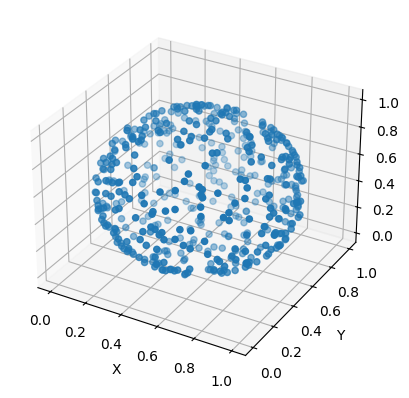

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Chair ModelNet10のインポート

In [ ]:
# 点群生成とクラスター化
def create_chair_points(num_points=500, radius=1.0):
    file_names = [f"/content/drive/MyDrive/chair/chair_{i:04d}.off" for i in range(1,2)]
    for file_name in file_names:
        with open(file_name, 'r') as f:
            verts, faces = read_off(f)
            i,j,k = np.array(faces).T
            x,y,z = np.array(verts).T

            pointcloud = PointSampler(num_points)((verts,faces))

            # traindata
            train_x = pointcloud[:,0]
            train_y = pointcloud[:,1]
            train_z = pointcloud[:,2]
            # Convert NumPy arrays to PyTorch tensors before normalization
            train_x = torch.tensor(train_x)
            train_y = torch.tensor(train_y)
            train_z = torch.tensor(train_z)
            train_xn = (train_x - train_x.min() )/ (train_x.max() - train_x.min())
            train_yn = (train_y - train_y.min() )/ (train_y.max() - train_y.min())
            train_zn = (train_z - train_z.min() )/ (train_z.max() - train_z.min())
            return torch.stack([train_xn, train_yn, train_zn], dim=1)


In [ ]:
# prompt: 下記のdef compute_laplacian_without_clusteringの2階微分を1回偏微分を2乗することで代替したい

# ======================================================================================================
# クラスタリングなしのラプラシアンの計算（2階微分を1階偏微分の2乗で近似）
def compute_laplacian(model, points):
    points.requires_grad_(True)
    T = model(points)

    # 勾配 (一次微分) の計算
    grad_T = torch.autograd.grad(outputs=T, inputs=points,
                                 grad_outputs=torch.ones_like(T),
                                 create_graph=True)[0]

    # 1階偏微分の2乗和でラプラシアンを近似
    laplacian = torch.sum(grad_T**2, dim=1).mean()

    return laplacian